#Read the Input Data

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

train = pd.read_csv("../input/incident-impact-prediction/train.csv")
test = pd.read_csv("../input/incident-impact-prediction/test.csv")

In [2]:
Y = train.impact
train.drop(['impact'], axis=1, inplace=True)
X = train
del train

In [3]:
X.drop(['Unnamed: 0', 'created_at', 'updated_at'], axis=1, inplace=True)
print(test.columns)
test.drop(['S.No', 'created_at', 'updated_at'], axis=1, inplace=True)
print(Y.shape, X.shape)
print(Y.describe())
print(X.describe())
categorical = [col for col in X.columns if X[col].dtype==object]
numerical = [col for col in X.columns if X[col].dtype!=object]
print(categorical, len(categorical))
print(numerical, len(numerical))

Index(['S.No', 'ID', 'ID_status', 'active', 'count_reassign', 'count_opening',
       'count_updated', 'ID_caller', 'opened_by', 'opened_time', 'Created_by',
       'created_at', 'updated_by', 'updated_at', 'type_contact', 'location',
       'category_ID', 'user_symptom', 'Support_group', 'support_incharge',
       'Doc_knowledge', 'confirmation_check', 'notify', 'problem_ID',
       'change_request'],
      dtype='object')
(99198,) (99198, 22)
count          99198
unique             3
top       2 - Medium
freq           94034
Name: impact, dtype: object
       count_reassign  count_opening  count_updated
count    99198.000000   99198.000000   99198.000000
mean         1.110426       0.022289       5.096857
std          1.751588       0.211605       7.748275
min          0.000000       0.000000       0.000000
25%          0.000000       0.000000       1.000000
50%          1.000000       0.000000       3.000000
75%          1.000000       0.000000       6.000000
max         27.000000  

In [4]:
for col in categorical:
    temp = {}
    count = 0
    for val in X[col].values:
        try:
            temp[val]
        except:
            temp[val] = count
            count += 1
    for val in test[col].values:
        try:
            temp[val]
        except:
            temp[val] = count
            count += 1
    X[col] = [temp[x] for x in X[col].values]
    test[col] = [temp[x] for x in test[col].values]
print(X[categorical])

          ID  ID_status  ID_caller  opened_by  opened_time  Created_by  \
0          0          0          0          0            0           0   
1          0          1          0          0            0           0   
2          0          2          0          0            0           0   
3          1          3          0          1            1           1   
4          1          3          0          1            1           1   
...      ...        ...        ...        ...          ...         ...   
99193  24567          1       2803         70        19618           2   
99194  24567          2       2803         70        19618           2   
99195  24568          3       2803         70        19619           2   
99196  24568          3       2803         70        19619           2   
99197  24568          1       2803         70        19619           2   

       updated_by  type_contact  location  category_ID  user_symptom  \
0               0             0        

#Data Processing

/opt/conda/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


              features  uniques
0                   ID    24569
1            ID_status        9
2               active        2
3       count_reassign       28
4        count_opening        9
5        count_updated      113
6            ID_caller     5223
7            opened_by      208
8          opened_time    19620
9           Created_by      186
10          updated_by      751
11        type_contact        5
12            location      225
13         category_ID       57
14        user_symptom      516
15       Support_group       78
16    support_incharge      232
17       Doc_knowledge        2
18  confirmation_check        2
19              notify        2
20          problem_ID      242
21      change_request      178


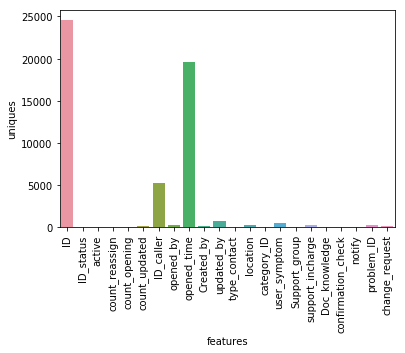

In [5]:
#Eliminate the NAN
for col in X.columns:
    X.loc[X[col] == '?', col] = 0

#Check the unique values
import seaborn as sns
nu = X.nunique().reset_index()
nu.columns = ['features', 'uniques']
ax = sns.barplot(x='features', y='uniques', data=nu)
ax.tick_params(axis='x', rotation=90)
print(nu)

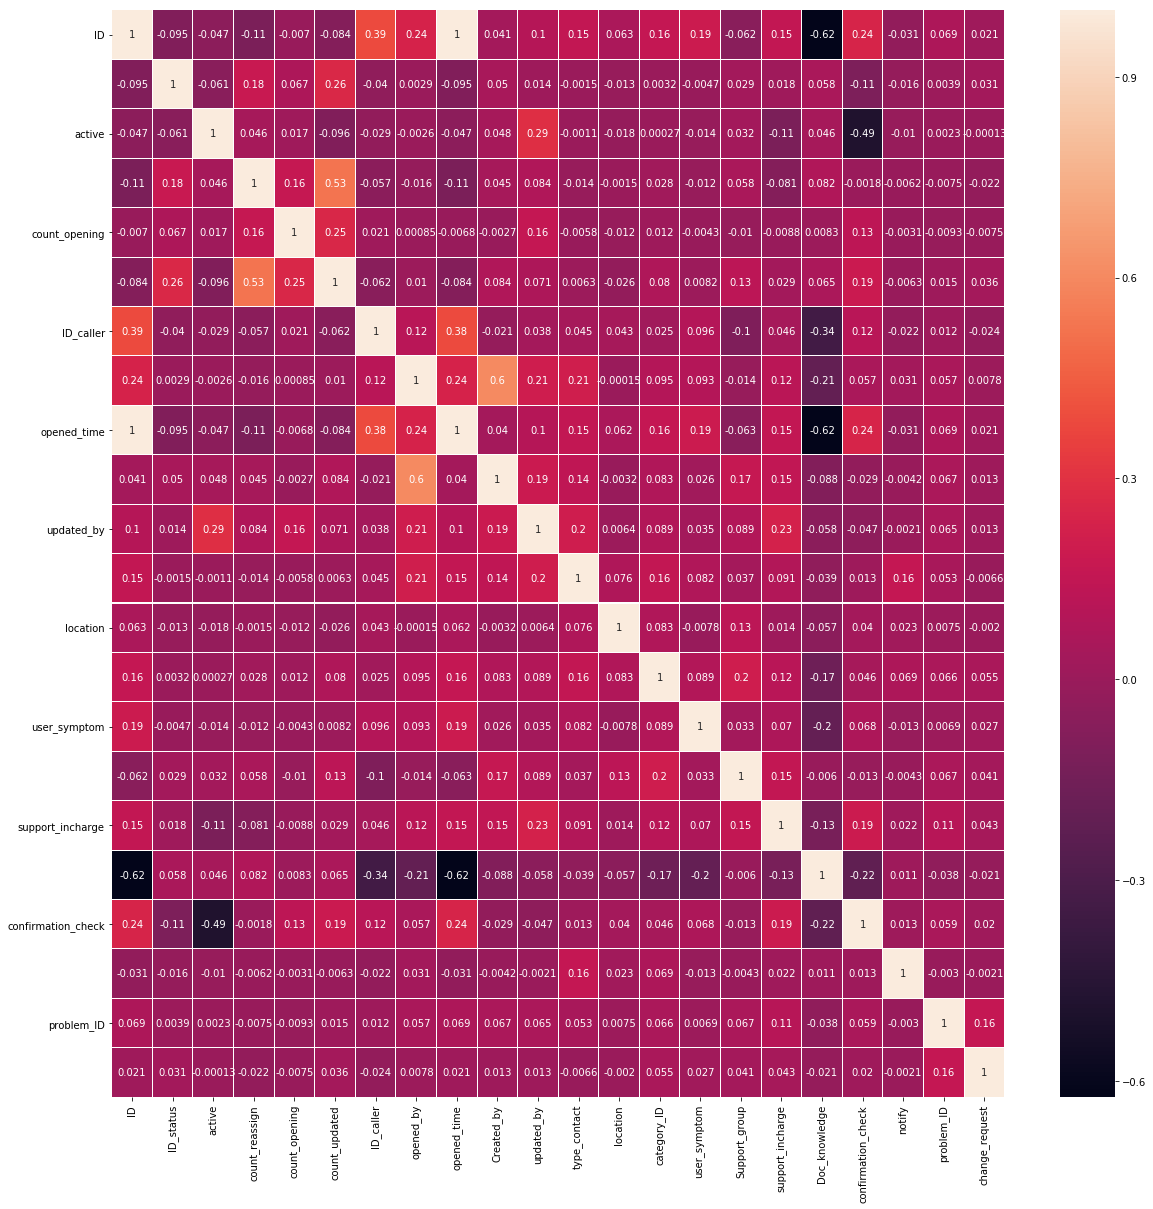

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(X.corr(), annot=True, linewidth=0.02)
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

In [7]:
corr = X.corr()
drop_cols = []
for col in X.columns:
    if sum(corr[col].map(lambda x: abs(x) > 0.1)) <= 4:
        drop_cols.append(col)
X.drop(drop_cols, axis=1, inplace=True)
print(drop_cols)
display(X)

['ID_status', 'active', 'location', 'user_symptom', 'notify', 'problem_ID', 'change_request']


,ID,count_reassign,count_opening,count_updated,ID_caller,opened_by,opened_time,Created_by,updated_by,type_contact,category_ID,Support_group,support_incharge,Doc_knowledge,confirmation_check
0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,False
1,0,0,0,3,0,0,0,0,1,0,0,0,0,True,False
2,0,0,0,4,0,0,0,0,2,0,0,0,0,True,False
3,1,1,0,1,0,1,1,1,0,0,1,1,1,True,False
4,1,1,0,2,0,1,1,1,0,0,1,1,1,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99193,24567,1,0,3,2803,70,19618,2,159,1,7,33,131,False,True
99194,24567,1,0,4,2803,70,19618,2,159,1,7,33,131,False,True
99195,24568,0,0,0,2803,70,19619,2,2,1,7,2,131,False,False
99196,24568,1,0,1,2803,70,19619,2,9,1,7,33,0,False,False


In [8]:
from sklearn import tree, feature_extraction
from sklearn.model_selection import cross_val_score
clf = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=100,
    random_state=11
)

print(cross_val_score(clf, X, Y, cv=5))

[0.02847782 0.60720766 0.72273185 0.79551411 0.55832241]


#Checking the predictions

In [9]:
clf.fit(X, Y)
p = clf.predict(X)
predict = clf.predict(test.drop(drop_cols, axis=1))

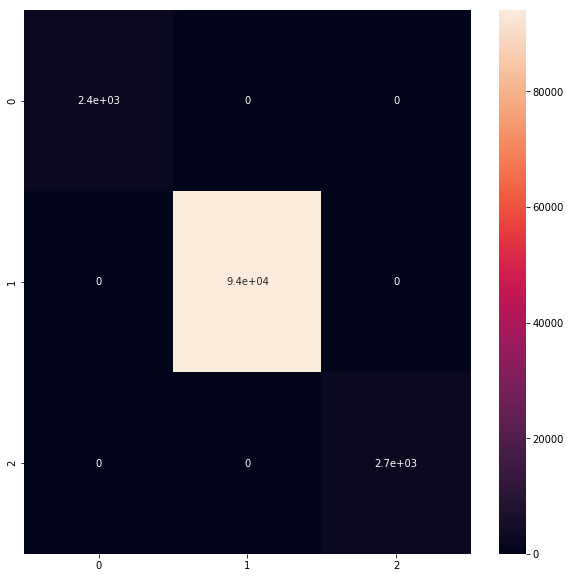

In [10]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cfm = confusion_matrix(Y, p)
sns.heatmap(cfm, annot=True)
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()

In [11]:
#Save Prediciton
ss = pd.DataFrame(zip([x for x in range(1, len(predict)+1)], predict), columns=['ID', 'prediction1'])
print(ss.shape)
ss.to_csv('submission.csv', index=False)

(42514, 2)
